In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models, utils
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize

In [3]:
training = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([ToTensor(), Normalize((0.5,),(0.5,))])
)

In [4]:
test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([ToTensor(), Normalize((0.5,),(0.5,))])
)

In [5]:
trainingloader = DataLoader(training, batch_size=64, shuffle=True)
testloader = DataLoader(test, batch_size=64, shuffle=True)

In [6]:
train_data = DataLoader(training, batch_size=64)
test_data = DataLoader(test, batch_size=64)

In [7]:
dataiter=iter(trainingloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


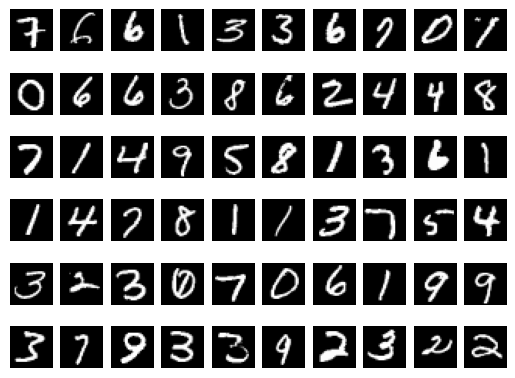

In [9]:
# Plotting images from the dataset

figure = plt.figure()

for i in range(1, 61):
    plt.subplot(6, 10, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')

In [10]:
device = ("cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [11]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train(dataloader, model, loss, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        modelLoss = loss(pred, y)

        modelLoss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if batch % 100 == 0:
        loss, current = modelLoss.item(), (batch+1) * len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [17]:
def test(dataloader, model, loss):
    size=len(dataloader.dataset)
    batches=len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}% \nAvg loss: {test_loss:>8f} \n")

In [18]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data, model, loss, optimizer)
    test(test_data, model, loss)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 97.2% 
Avg loss: 0.125893 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.6% 
Avg loss: 0.114950 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.4% 
Avg loss: 0.123686 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.2% 
Avg loss: 0.123666 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.1% 
Avg loss: 0.145539 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 97.2% 
Avg loss: 0.149283 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 97.1% 
Avg loss: 0.143553 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.4% 
Avg loss: 0.146078 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 96.9% 
Avg loss: 0.170357 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.0% 
Avg loss: 0.178745 

Done!


In [19]:
def _view(img, ps):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit= 5


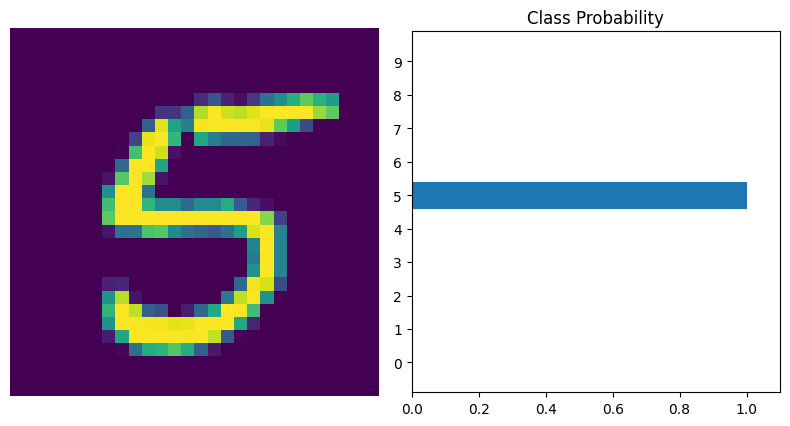

In [20]:
images, labels = next(iter(testloader))
img = images[0].view(1, 784)

with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
prob = list(ps.numpy()[0])
print("Predicted Digit=", prob.index(max(prob)))
_view(img.view(1,28,28), ps)

In [21]:
torch.save(model, './mnist.pt')